# Policy Gradients: REINFORCE Baseline with LunarLander

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [2]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### LunarLander

LunarLander is an OpenAI gym environment (env). In this env the agent tries to land a space craft safely on the ground by firing the main, left, or right engine. The agent receives a reward for navigating to the landing pad and turning off the engine, a large reward for a safe landing, a large negative reward for an unsafe landing, and a small negative reward for using the engines. There are discrete and continuous versions of LunarLander.

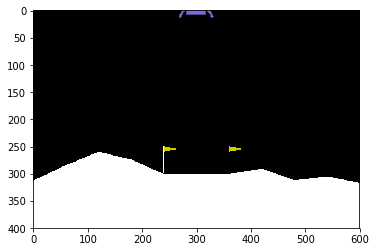

In [3]:
env = gym.make('LunarLander-v2')
env.reset()

prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(200):
    env.render()
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()
        
env.close()

### Policy Gradient Methods

In policy gradient methods, we update the policy directly. Ie we parameterize the policy and perform gradient descent updates on the policy parameters seeking to improve the policy. This is in contrast to section 3 where we learned estimates of the state or action-values. Then we extracted a policy based on those values, like with the epsilon greedy DQN policy.

### Discrete vs. Continuous Action Spaces

PG methods can work in discrete and continuous action spaces. The DQN method we went over in section three required discrete action spaces: ie a limited number of actions. In continuous actions spaces there are an infinite number of actions as the action can be any value in a range. Continuous action spaces are often parameterized by a probability distribution and we learn the parameters of the distribution. For example we assume the actions come from a Gaussian distribution and try to learn the mean and standard deviation of the Gaussian that leads to the best policy. 

### REINFORCE with Lunar Lander

In this example, we will solve the discrete version of Lunar Lander using the REINFORCE with baseline method.

In [4]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x),dim=-1) #-1 to take softmax of last dimension
    
class ValueFunctionNet(nn.Module):
    def __init__(self, state_size, hidden_size):
        super(ValueFunctionNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

In [5]:
class PGAgent():
    def __init__(self, state_size, action_size, hidden_size, actor_lr, vf_lr, discount ):
        self.action_size = action_size
        self.actor_net = ActorNet(state_size, action_size, hidden_size).to(device)
        self.vf_net = ValueFunctionNet(state_size, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=actor_lr)
        self.vf_optimizer = optim.Adam(self.vf_net.parameters(), lr=vf_lr)
        self.discount = discount
        
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action_probs = self.actor_net(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action_probs = action_probs.detach().cpu().numpy()
            action = np.random.choice(np.arange(self.action_size), p=action_probs)
        return action

    def train(self, state_list, action_list, reward_list):
        
        #turn rewards into return
        trajectory_len = len(reward_list)
        return_array = np.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len-1,-1,-1):
            g_return = reward_list[i] + self.discount*g_return
            return_array[i] = g_return
            
        # create tensors
        state_t = torch.FloatTensor(state_list).to(device)
        action_t = torch.LongTensor(action_list).to(device).view(-1,1)
        return_t = torch.FloatTensor(return_array).to(device).view(-1,1)
        
        # get value function estimates
        vf_t = self.vf_net(state_t).to(device)
        with torch.no_grad():
            advantage_t = return_t - vf_t
        
        # calculate actor loss
        selected_action_prob = self.actor_net(state_t).gather(1, action_t)
        # REINFORCE loss:
        #actor_loss = torch.mean(-torch.log(selected_action_prob) * return_t)
        # REINFORCE Baseline loss:
        actor_loss = torch.mean(-torch.log(selected_action_prob) * advantage_t)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step() 

        # calculate vf loss
        loss_fn = nn.MSELoss()
        vf_loss = loss_fn(vf_t, return_t)
        self.vf_optimizer.zero_grad()
        vf_loss.backward()
        self.vf_optimizer.step() 
        
        return actor_loss.detach().cpu().numpy(), vf_loss.detach().cpu().numpy()
    

In [6]:
# initialize environment
env = gym.make('LunarLander-v2')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = 5000 # run agent for this many episodes
hidden_size = 256 # number of units in NN hidden layers
actor_lr = 0.002 # learning rate for actor
value_function_lr = 0.002 # learning rate for value function
discount = 0.99 # discount factor gamma value
reward_scale = 0.01 #scale reward by this amount

# create agent
agent = PGAgent(state_size, action_size, hidden_size, actor_lr, value_function_lr, discount)

In [7]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_vf_loss = 0., 0.

for ep in range(episodes):
    state = env.reset()
    state_list, action_list, reward_list = [], [], []
    
    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  

    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.select_action(state)
        
        # enter action into the env
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        # store agent's trajectory
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward*reward_scale)
        
        # end episode early
        if total_reward < -250:
            done = 1
        
        if done:
            actor_loss, vf_loss = agent.train(state_list, action_list, reward_list)
            stats_rewards_list.append((ep, total_reward, episode_length))
            stats_actor_loss += actor_loss
            stats_vf_loss += vf_loss
            total_reward = 0
            episode_length = 0  
            if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Actor Loss: {:.4f}'.format(stats_actor_loss/stats_every), 
                    'VF Loss: {:.4f}'.format(stats_vf_loss/stats_every))
                stats_actor_loss, stats_vf_loss = 0., 0.
            break
        
        state = next_state


Episode: 0 Timestep: 58 Total reward: -112.2 Episode length: 58.0 Actor Loss: -0.0900 VF Loss: 0.0421
Episode: 10 Timestep: 1131 Total reward: -247.7 Episode length: 107.3 Actor Loss: -0.0414 VF Loss: 0.3992
Episode: 20 Timestep: 2043 Total reward: -252.0 Episode length: 91.2 Actor Loss: -0.2468 VF Loss: 0.3471
Episode: 30 Timestep: 2859 Total reward: -253.9 Episode length: 81.6 Actor Loss: 0.0386 VF Loss: 0.2227
Episode: 40 Timestep: 3506 Total reward: -254.8 Episode length: 64.7 Actor Loss: -0.0263 VF Loss: 0.1408
Episode: 50 Timestep: 4154 Total reward: -253.0 Episode length: 64.8 Actor Loss: 0.0189 VF Loss: 0.1289
Episode: 60 Timestep: 4872 Total reward: -252.9 Episode length: 71.8 Actor Loss: -0.0551 VF Loss: 0.1549
Episode: 70 Timestep: 5503 Total reward: -254.9 Episode length: 63.1 Actor Loss: 0.0315 VF Loss: 0.0923
Episode: 80 Timestep: 6264 Total reward: -262.3 Episode length: 76.1 Actor Loss: 0.0062 VF Loss: 0.1041
Episode: 90 Timestep: 7006 Total reward: -252.3 Episode lengt

Episode: 770 Timestep: 362501 Total reward: 53.1 Episode length: 665.5 Actor Loss: -0.0218 VF Loss: 0.1370
Episode: 780 Timestep: 371018 Total reward: 71.9 Episode length: 851.7 Actor Loss: 0.0293 VF Loss: 0.0850
Episode: 790 Timestep: 378016 Total reward: 71.5 Episode length: 699.8 Actor Loss: 0.0060 VF Loss: 0.1383
Episode: 800 Timestep: 385702 Total reward: 26.6 Episode length: 768.6 Actor Loss: -0.0288 VF Loss: 0.1576
Episode: 810 Timestep: 392619 Total reward: 145.2 Episode length: 691.7 Actor Loss: 0.0815 VF Loss: 0.1132
Episode: 820 Timestep: 397888 Total reward: 135.5 Episode length: 526.9 Actor Loss: 0.0016 VF Loss: 0.1775
Stopping at episode 829 with average rewards of 190.02706561909008 in last 10 episodes


Text(0, 0.5, 'Episode Reward')

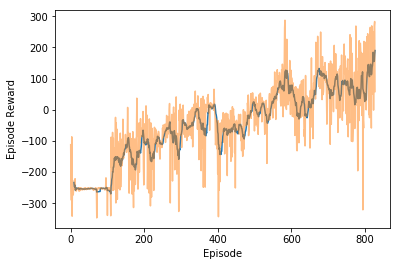

In [8]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

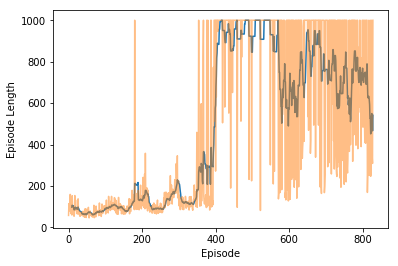

In [9]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')